In [1]:
import pandas as pd

df_ff_train = pd.read_csv("tep_faultfree_training.csv")
df_ff_test = pd.read_csv("tep_faultfree_testing.csv")
df_f_train = pd.read_csv("tep_faulty_training.csv")
df_f_test = pd.read_csv("tep_faulty_testing.csv")

df_ff_train["label"] = 0
df_f_train["label"] = 1
df_ff_test["label"] = 0
df_f_test["label"] = 1

df_train_combined = pd.concat(
    [df_ff_train, df_f_train],
    axis=0,          
    ignore_index=True
)

df_test_combined = pd.concat(
    [df_ff_test, df_f_test],
    axis=0,
    ignore_index=True
)

from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_df(df, scaler):

    features_scaled = scaler.transform(df.iloc[:, :55])
    labels = df.iloc[:, 55:56].to_numpy().reshape(-1, 1)
    X_scaled = np.hstack([features_scaled, labels])
    df_scaled = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)

    return df_scaled

scaler = StandardScaler()
scaler.fit(df_ff_train.iloc[:, :55])
df_ff_train = scale_df(df_ff_train, scaler)
df_test_combined = scale_df(df_test_combined, scaler)
df_train_combined = scale_df(df_train_combined, scaler)

print(df_ff_train.shape, df_test_combined.shape)
print(df_test_combined["label"].value_counts())

(25000, 56) (110400, 56)
label
1.0    62400
0.0    48000
Name: count, dtype: int64


## PCA setup - same as task 1

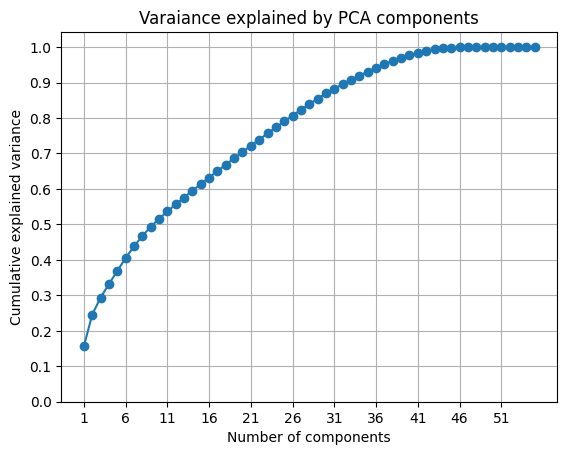

Explained variance by the first 10 components:
PC1: 15.59%
PC2: 8.92%
PC3: 4.83%
PC4: 3.79%
PC5: 3.73%
PC6: 3.63%
PC7: 3.29%
PC8: 2.93%
PC9: 2.59%
PC10: 2.23%


In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_train = df_ff_train.iloc[:, :55].values
y_train = df_ff_train["label"].values

X_test = df_test_combined.iloc[:, :55].values
y_test = df_test_combined["label"].values

pca3 = PCA(n_components=55)
pca3.fit(X_train)

x = np.arange(1, len(pca3.explained_variance_ratio_[0:-1]) + 2)

plt.plot(x,np.cumsum(pca3.explained_variance_ratio_),marker='o')
plt.title('Varaiance explained by PCA components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xticks(range(1, 56, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()

print("Explained variance by the first 10 components:")
for i in range(10):
    print(f"PC{i+1}: {pca3.explained_variance_ratio_[i]*100:.2f}%")


pca3 = PCA(n_components=21)
pca3.fit(X_train)

X_test_pca = pca3.transform(X_test)
X_train_pca = pca3.transform(X_train)

## KMeans clustering

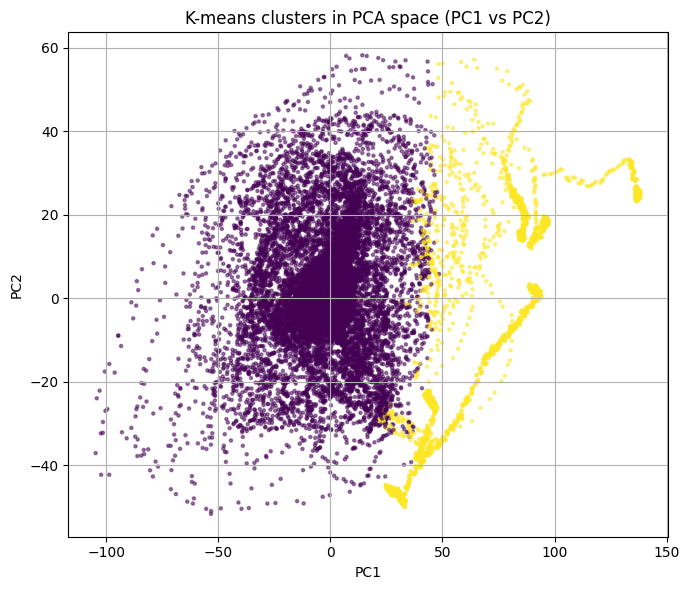

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = 2
kmeans = KMeans(n_clusters=k, random_state=69, n_init='auto').fit(X_test_pca)
cluster_test = kmeans.predict(X_test_pca)

plt.figure(figsize=(7, 6))

plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=cluster_test,     
    cmap='viridis',
    s=5,
    alpha=0.5
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters in PCA space (PC1 vs PC2)")
plt.grid(True)
plt.tight_layout()
plt.show()

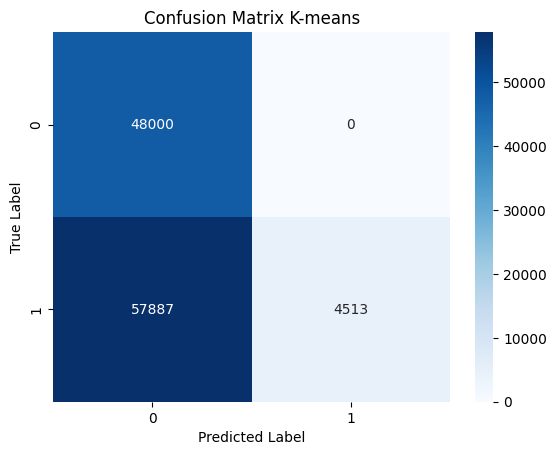

              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62     48000
         1.0       1.00      0.07      0.13     62400

    accuracy                           0.48    110400
   macro avg       0.73      0.54      0.38    110400
weighted avg       0.76      0.48      0.35    110400



In [4]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cf = confusion_matrix(y_test, cluster_test)
# Plot
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix K-means")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, cluster_test))

## DBSCAN

### KNN elbow

In [5]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=21)
neighbors_fit = neighbors.fit(X_test_pca)
distances, indices = neighbors_fit.kneighbors(X_test_pca)
distances = np.sort(distances[:, -1])

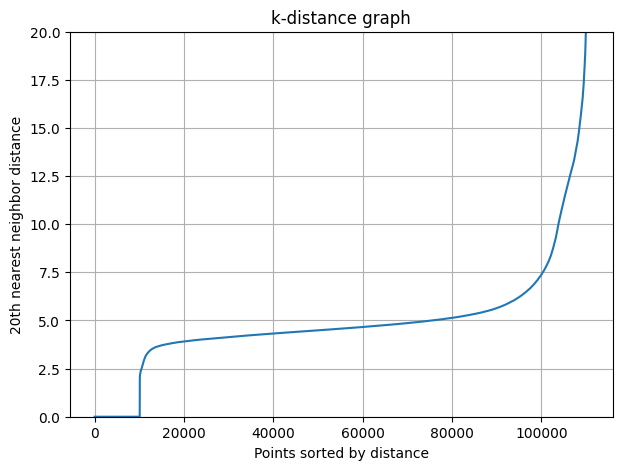

In [6]:
plt.figure(figsize=(7,5))
plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("20th nearest neighbor distance")
# plt.xlim(80000, 115000)
plt.ylim(0, 20)
plt.grid(True)
plt.show()

## DBSCAN

### note
when running eps values too high, we oobviously include more noise into clusters 

In [ ]:
from sklearn.cluster import DBSCAN
import json
from sklearn.metrics import confusion_matrix, accuracy_score

eps_values = np.arange(4.8 ,5.2, 0.1)

min_samples_list = []
loop_counter=0
total_loops = len(eps_values) * len(min_samples_list)

for eps in eps_values:
        
    for min_samples in min_samples_list:
        loop_counter += 1
        print(f"[{loop_counter}/{total_loops}] Running DBSCAN with eps={eps}, min_samples={min_samples}")
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=1).fit(X_test_pca)
        db_labels = db.labels_

        y_pred = np.where(db_labels == -1, 1, 0)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        fnr = fn / (fn + tp)
        fpr = fp / (fp + tn)

        outliers = np.sum(db_labels == -1)
        ratio_outliers = outliers / (np.sum(y_test == 1))

        accuracy = accuracy_score(y_test, y_pred)

        entry = {
            "eps": float(eps),
            "min_samples": int(min_samples),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "fnr": float(fnr),
            "fpr": float(fpr),
            "accuracy": float(accuracy),
            "outliers": int(outliers),
            "outlier_ratio": float(ratio_outliers),
            "y_pred": y_pred.tolist(),
            "db_labels": db_labels.tolist()
            }
        
        with open("DBscan_results.jsonl", "a") as f:
                f.write(json.dumps(entry) + "\n")


[1/25] Running DBSCAN with eps=4.8, min_samples=10
[2/25] Running DBSCAN with eps=4.8, min_samples=15
[3/25] Running DBSCAN with eps=4.8, min_samples=25
[4/25] Running DBSCAN with eps=4.8, min_samples=30
[5/25] Running DBSCAN with eps=4.8, min_samples=35
[6/25] Running DBSCAN with eps=4.8999999999999995, min_samples=10
[7/25] Running DBSCAN with eps=4.8999999999999995, min_samples=15
[8/25] Running DBSCAN with eps=4.8999999999999995, min_samples=25
[9/25] Running DBSCAN with eps=4.8999999999999995, min_samples=30
[10/25] Running DBSCAN with eps=4.8999999999999995, min_samples=35
[11/25] Running DBSCAN with eps=4.999999999999999, min_samples=10
[12/25] Running DBSCAN with eps=4.999999999999999, min_samples=15
[13/25] Running DBSCAN with eps=4.999999999999999, min_samples=25
[14/25] Running DBSCAN with eps=4.999999999999999, min_samples=30
[15/25] Running DBSCAN with eps=4.999999999999999, min_samples=35
[16/25] Running DBSCAN with eps=5.099999999999999, min_samples=10
[17/25] Running DB

In [13]:
results_df = pd.read_json('DBscan_results.jsonl',lines=True)
pd.set_option('display.max_rows', 5)
results_df.iloc[:,:].sort_values(by=["f1"], ascending=False)

,eps,min_samples,precision,recall,f1,fnr,fpr,accuracy,outliers,outlier_ratio,y_pred,db_labels
28,2.5,50,0.562743,0.989391,0.717429,0.010609,0.999396,0.559484,109709,1.758157,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
45,2.6,45,0.562139,0.986843,0.716268,0.013157,0.999271,0.558098,109544,1.755513,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...
24,5.8,21,0.998078,0.208029,0.344296,0.791971,0.000521,0.552138,13006,0.208429,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,8.0,20,1.000000,0.114647,0.205711,0.885353,0.000000,0.499583,7154,0.114647,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


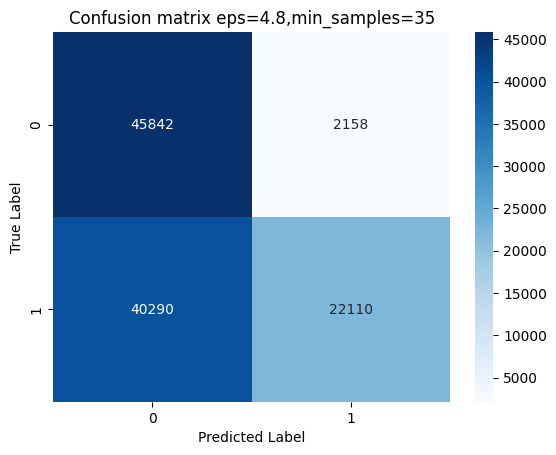

              precision    recall  f1-score   support

         0.0       0.53      0.96      0.68     48000
         1.0       0.91      0.35      0.51     62400

    accuracy                           0.62    110400
   macro avg       0.72      0.65      0.60    110400
weighted avg       0.75      0.62      0.59    110400



In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

row = 95
y_pred = results_df.loc[row, "y_pred"]
cm2 = confusion_matrix(y_test, y_pred)
labels = results_df.loc[row,"db_labels"]
eps = results_df.loc[row,"eps"]
min_samples = results_df.loc[row,"min_samples"]

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion matrix eps={eps},min_samples={min_samples}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred))


I think that this should be the most balanced results, although we can aim for a high recall in the cost of false positives

### Scatterplot

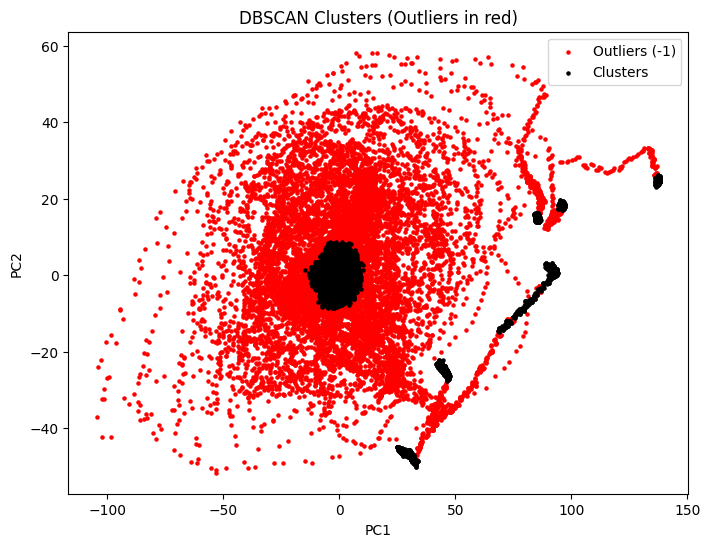

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

row = 95
labels = np.array(results_df["db_labels"].iloc[row])  # välj rätt rad om du har flera modeller


mask_outliers = labels == -1
mask_inliers = labels != -1

plt.figure(figsize=(8, 6))

plt.scatter(
    X_test_pca[mask_outliers, 0],
    X_test_pca[mask_outliers, 1],
    s=5,
    c="red",
    label="Outliers (-1)"
)
plt.scatter(
    X_test_pca[mask_inliers, 0],
    X_test_pca[mask_inliers, 1],
    s=5,
    c="black",
    label="Clusters"
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN Clusters (Outliers in red)")
plt.legend()
plt.show()


## Short report

So after countless hours of testing and asking fellow student collegues, I have concluded that this type of clustering cannot and will never be applicable solution to this problem, atleast with my lack of understanding. I feel like that the dataset was not pre-processed enough to separate the faulty data from the non-faulty, hence the terrible performance. As seen in task 1, with the t2 metric, the overlap is the big problem to achieve a good anomaly detection. I hope to get some feedback! Sorry for the delay.

My takeaways from this task is that dbscan was a nice refresher. 

What i would like is a clearer picture of how good of a performance we should be able to get on this dataset.